In [37]:
using Plots, ComplexPhasePortrait, Interact, ApproxFun, Statistics, SpecialFunctions, LinearAlgebra
gr();

periodic_rule(n) = 2π/n*(0:(n-1)), 2π/n*ones(n)

function circle_rule(n, r) 
    θ = periodic_rule(n)[1]
    r*exp.(im*θ), 2π*im*r/n*exp.(im*θ)
end

function ellipse_rule(n, a, b) 
    θ = periodic_rule(n)[1]
    a*cos.(θ) + b*im*sin.(θ), 2π/n*(-a*sin.(θ) + im*b*cos.(θ))
end

ellipse_rule (generic function with 1 method)

$$
\def\I{{\rm i}}
\def\E{{\rm e}}
\def\D{{\rm d}}
$$

# M3M6: Methods of Mathematical Physics

Dr. Sheehan Olver
<br>
s.olver@imperial.ac.uk


# Lecture 4: Trapezium rule, Fourier series and Laurent series


This lecture we cover

1. Periodic and complex Trapezium rule    
    - Application: Calculating matrix exponentials
    - Gershorwin's theorem
1. Laurent series and Fourier series
    - Application: Decay of Fourier coefficients

### Periodic and complex Trapezium rule

Quadrature rules are pairs of _nodes_ $x_0,\ldots,x_{n-1}$ and weights $w_0,\ldots,w_{n-1}$ to approximate integrals
$$
\int_a^b f(x) dx \approx \sum_{j=0}^{n-1} w_j f(x_j)
$$
In this lecture we construct quadrature rules on complex contours $\gamma$ to approximate contour integrals.


The trapezium rule gives an easy approximation to integrals. On $[0,2\pi)$ for periodic $f(\theta)$, we have a simplified form:

**Definition (Periodic trapezium rule)** The _periodic trapezium rule_ is the approximation

$$\int_0^{2 \pi} f(\theta) d \theta \approx {2\pi \over n} \sum_{j=0}^{n-1} f(\theta_k)$$

for $\theta_j = {2 \pi j \over n}$.

The periodic trapezium rule is amazingly accurate for smooth, periodic functions:

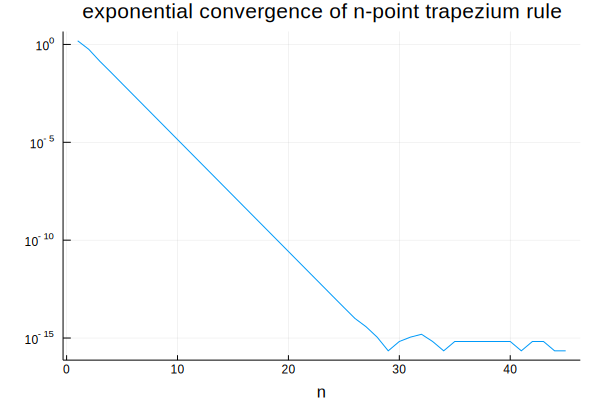

In [2]:
f = θ ->  1/(2 + cos(θ))

errs = [((x, w) = periodic_rule(n); abs(sum(w.*f.(x)) - sum(Fun(f, 0 .. 2π)))) for n = 1:45];
plot(errs.+eps(); yscale=:log10, title="exponential convergence of n-point trapezium rule", legend=false, xlabel="n")

The accuracy in integration is remarkable as the trapezoidal interpolant does not accurately approximate $f$: we can see clear differences between the functions here:

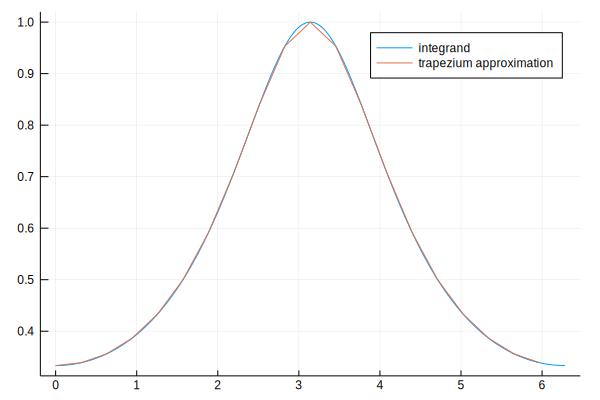

In [3]:
n=20
(x, w) = periodic_rule(n)
plot(Fun(f, 0 .. 2π); label = "integrand")
plot!(x, f.(x); label = "trapezium approximation")

### Complex Trapezium rule

We can use the map that defines a contour to construct an approximation to integrals over closed contour $\gamma$:

**Definition (Complex trapezium rule)** The _complex trapezium rule_ on a contour $\gamma$ (mapped from $[0,2\pi)$) is the approximation

$$\oint_\gamma f(z) dz \approx  \sum_{j=0}^{n-1} w_j f(z_j)$$

for

$$z_j = \gamma(\theta_j) \qquad\hbox{and}\qquad w_j = {2\pi \over n} \gamma'(\theta_j)$$


*Example (Circle trapezium rule)* On a circle $\{r e^{i \theta} : 0 \leq \theta < 2 \pi\}$, we have 

$$\oint_\gamma f(z) dz \approx  \sum_{j=0}^{n-1} w_j f(z_j)$$

for $z_j = r e^{i \theta_j}$ and $w_j = {2 \pi i r \over n}  e^{i \theta_j}$.

Here we plot the quadrature points:

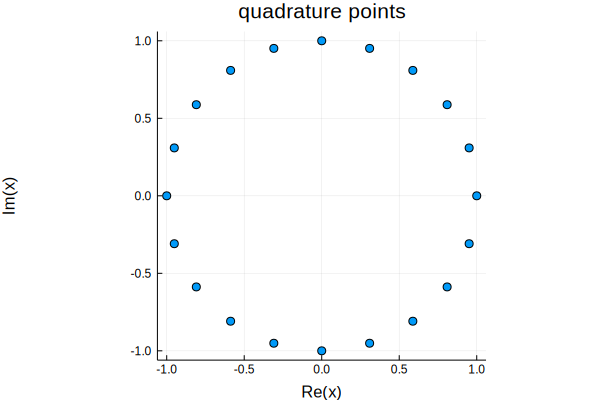

In [27]:
ζ, w = circle_rule(20, 1.0)
scatter(ζ; title="quadrature points", legend=false, ratio=1.0)

The Circle trapezium rule is surprisingly accurate for analytic functions:

In [5]:
ζ, w = circle_rule(20, 1.0)

f = z -> cos(z)

z = 0.1+0.2im

sum(f.(ζ)./(ζ .- z).*w)/(2π*im) - f(z)

-9.814371537686384e-14 - 1.3111040031432708e-14im

### Application: Numerical differentiation

Calculating high-order derivatives using limits is numerically unstable. Here is a demonstration using finite-difference: making $h$ small does not increase the accuracy after a certain point:

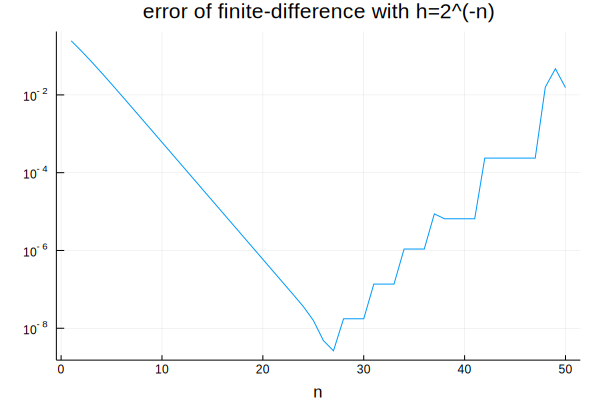

In [30]:
f = z -> gamma(z)
fp = z -> gamma(z)polygamma(0,z) # exact derivative 
x = 1.2
fp_fd = [(h=2.0^(-n);  (f(x+h)-f(x))/h) for n = 1:50]
plot(abs.(fp_fd .- fp(x)); yscale=:log10, legend=false, title = "error of finite-difference with h=2^(-n)", xlabel="n")

But the previous formula tells us that we can reduce a derivative to a contour integral.  The example above shows that it's still numerically unstable, but we can deform the integration contour, to make it stable! 

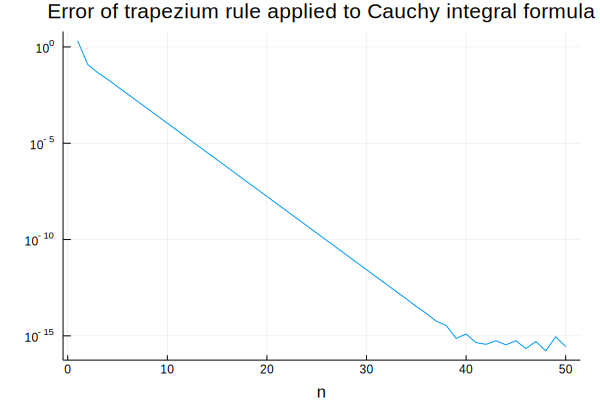

In [31]:
trap_fp = [((ζ, w) = circle_rule(n, 0.5); 
        ζ .+= x; # circle around x
       sum(f.(ζ)./(ζ .- x).^2 .*w)/(2π*im)) for n=1:50]

plot(abs.(trap_fp .- fp.(x)); yscale=:log10, 
       title="Error of trapezium rule applied to Cauchy integral formula", xlabel="n", legend=false)

We can take things further and use this to calculate the higher order derivatives, with some care taken for choosing the radius:

In [32]:
k=100
r = 1.0k
g = Fun( ζ -> exp(ζ)/(ζ - 0.1)^(k+1), Circle(0.1,r))
factorial(1.0k)/(2π*im) * sum(g) - exp(0.1)

-7.993605777301127e-15 + 3.675487826103639e-16im

[Bournemann 2011](https://www-m3.ma.tum.de/foswiki/pub/M3/Allgemeines/FolkmarBornemannPublications/FoCM_Stability_Cauchy_Integrals.pdf) investigates this further and optimizes the radius.

The exponential convergence of the complex trapezium rule is a consequence of $f(\gamma(t))$ being 2π-periodic, as we will see later in a few lectures:

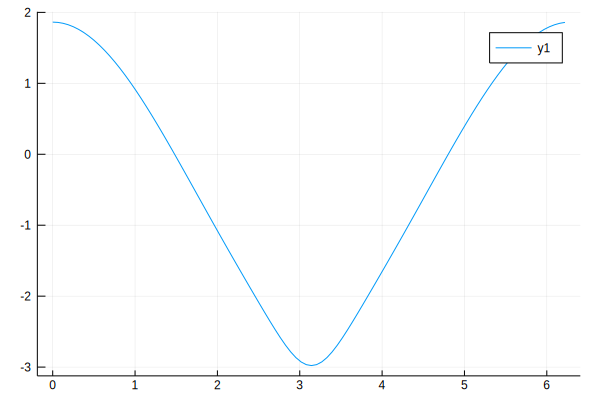

In [33]:
θ = periodic_rule(100)[1]
plot(θ, real(f.(0.6exp.(im*θ) .+ x)./(0.5exp.(im*θ))))

*Example (Ellipse trapezium rule)* On an ellipse $\{a \cos \theta + b i \sin \theta : 0 \leq \theta < 2 \pi\}$ we have 
$$\oint_\gamma f(z) dz \approx  \sum_{j=0}^{n-1} w_j f(z_j)$$
for $z_j = a \cos \theta_j + b i \sin \theta_j$ and $w_j = {2 \pi \over n} (-a \sin \theta_j + i b \cos \theta_j)$.

We can use the ellipse trapezium rule in place of the circle trapzium rule and still achieve accurate results. This gives us flexibility in avoiding singularities. Consider
$$
f(z) = 1/(25z^2 + 1)
$$
which has poles at $\pm  \I/5$. Using an ellipse allows us to design a contour that avoids these singularities:

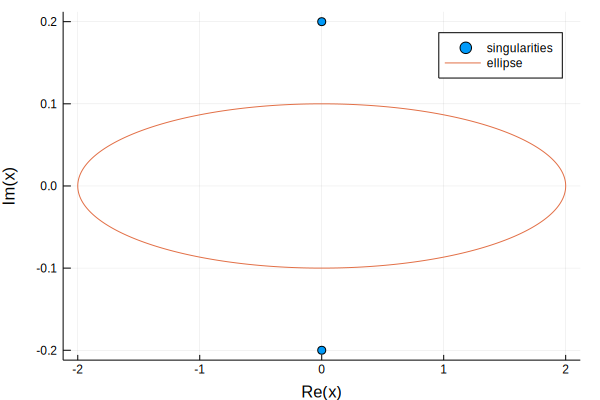

In [34]:
scatter([1/5im,-1/5im]; label="singularities")
θ = range(0; stop=2π, length=2000)
a = 2; b= 0.1
plot!(a * cos.(θ) + im*b * sin.(θ); label="ellipse")

Thus we can still use Cauchy's integral formula:

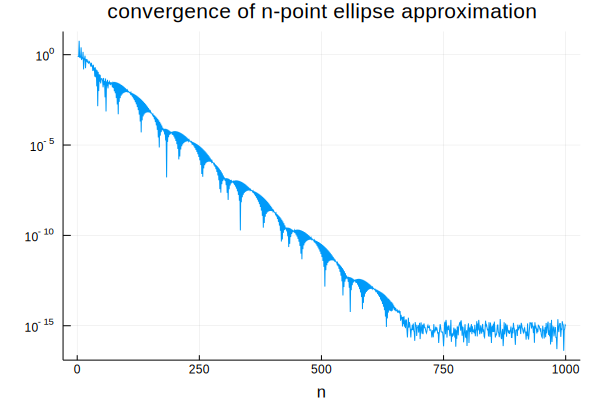

In [35]:
x = 0.1
f = z -> 1/(25z^2 + 1)

f_ellipse = [((z, w) = ellipse_rule(n, a, b); sum(f.(z)./(z.-x).*w)/(2π*im)) for n=1:1000]
plot(abs.(f_ellipse .- f(x)); yscale=:log10, title="convergence of n-point ellipse approximation", legend=false, xlabel="n")

### Taylor series versus Cauchy integral formula


The Taylor series gives a polynomial approximation to $f$. The Cauchy's integral formula discretisation gives a rational approximation, which is more adaptiple and does not require knowning the derivatives of $f$:

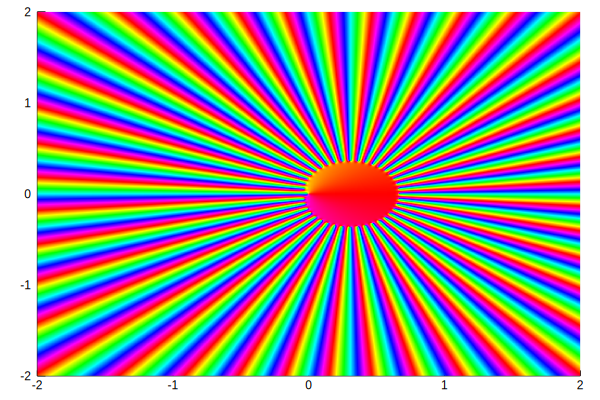

In [36]:
f = z -> sqrt(z)

function sqrtⁿ(n,z,z₀) 
    ret = sqrt(z₀)
    c = 0.5/ret*(z-z₀)
    for k=1:n
        ret += c
        c *= -(2k-1)/(2*(k+1)*z₀)*(z-z₀)
    end
    ret
end


z₀ = 0.3
n = 40
phaseplot(-2..2, -2..2, z -> sqrtⁿ.(n,z,z₀))

Here we see that the approximation is vallid on the expected ellipse:

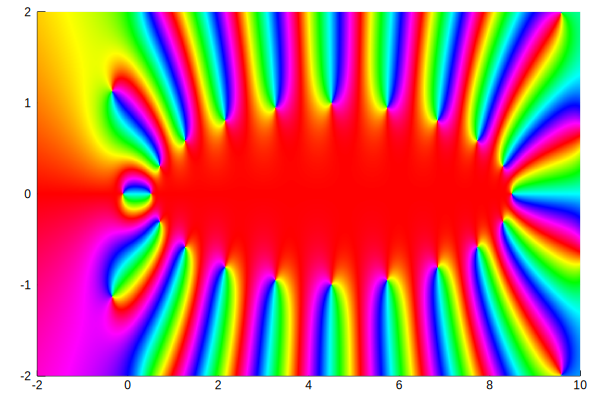

In [13]:
(ζ, w) = ellipse_rule(20, 4.0, 1.0);
ζ  .= ζ .+ 4.5;
f_c = z ->  sum(f.(ζ)./(ζ.-z).*w)/(2π*im)
phaseplot(-2..10, -2 .. 2, f_c)

In [14]:
(ζ, w) = ellipse_rule(100, 4.0, 1.0);
ζ  .= ζ .+ 4.5;
f_c = z ->  sum(f.(ζ)./(ζ.-z).*w)/(2π*im)
f_c(5.3) - sqrt(5.3)

-1.3987033753437572e-11 + 2.459960261444439e-16im

### Application: calculating matrix exponentials

Let $A \in {\mathbb C}^{d \times d}$,   ${\mathbf u}_0 \in {\mathbb C}^d$ and consider the constant coefficient linear ODE

$$
    {\mathbf u}'(t) = A {\mathbf u}(t)\qquad\hbox{and}\qquad {\mathbf u}(0) = {\mathbf u}_0(0)
    $$
    
The solution to this is given by the _matrix exponential_
$$
    {\mathbf u}(t) = \exp(A t) {\mathbf u}_0
    $$
    where the matrix exponential is defined by it's Taylor series:
$$
    \exp(A) = \sum_{k=0}^\infty {A^k \over k!}
    $$
This has stability problems, so a more convenient form is as follows:

**Theorem (Cauchy integral representation for matrix exponential)**
Let $A \in {\mathbb C}^{n \times n}$ be a diagonalizable matrix:
$$
    A = V \Lambda V^{-1} \qquad\hbox{for}\qquad\Lambda =
    \begin{pmatrix}\lambda_1 \cr &\ddots \cr && \lambda_d\end{pmatrix}
$$
Let $\gamma$ be a contour that surrounds the spectrum of $A$. Then we have
$$
    \exp(A) = {1 \over 2 \pi i} \oint_\gamma e^z (z I - A)^{-1} dz
    $$
    
**Proof** Note by definition
$$
\begin{align*}
\exp(A) &= \sum_{k=0}^\infty {A^k \over k!} = V \sum_{k=0}^\infty {\Lambda^k \over k!}V^{-1} = V \begin{pmatrix} \E^{\lambda_1}\\ & \ddots \\ && \E^{\lambda_d} \end{pmatrix} V^{-1}  \\
&= {1 \over 2\pi \I} V \begin{pmatrix} \oint_\gamma {\E^\zeta \over \zeta - \lambda_1 } \D\zeta \\ & \ddots \\ && \oint_\gamma {\E^\zeta \over \zeta - \lambda_d } \D\zeta\end{pmatrix} V^{-1} 
\end{align*}
$$
It was important here that $\gamma$ surrounded all $\zeta_j$.

We now take out the integration from the matrix, the easiest way to see this is to apply the Trapezium rule approximation:
$$
\begin{align*}
V\begin{pmatrix} \oint_\gamma {\E^\zeta \over \zeta - \lambda_1 } \D\zeta \\ & \ddots \\ && \oint_\gamma {\E^\zeta \over \zeta - \lambda_d } \D\zeta\end{pmatrix} V^{-1} &= V\lim_{n \rightarrow \infty} \begin{pmatrix} \sum_{j=1}^n {w_j \E^\zeta_j \over \zeta_j - \lambda_1 }  \\ & \ddots \\ && \sum_{j=1}^n {w_j \E^\zeta_j \over \zeta_j - \lambda_d } \end{pmatrix} V^{-1} \\
&= \lim_{n \rightarrow \infty}  V\sum_{j=1}^n w_j \E^\zeta_j \begin{pmatrix}  {1 \over \zeta_j - \lambda_1 }  \\ & \ddots \\ &&  {1 \over \zeta_j - \lambda_d } \end{pmatrix} V^{-1} \\
&= \lim_{n \rightarrow \infty}  \sum_{j=1}^n w_j \E^\zeta_j V(I \zeta_j - \Lambda)^{-1}V^{-1} \\
&= \oint_\gamma \E^\zeta V(I \zeta - \Lambda)^{-1} V^{-1} \D \zeta 
= \oint_\gamma \E^\zeta (I \zeta - V\Lambda V^{-1})^{-1}  \D \zeta \\
& = \oint_\gamma \E^\zeta (I \zeta - A)^{-1}  \D \zeta \\
\end{align*}
$$


■

_Demonstration_ we use this formula alongside the complex trapezium rule to calculate matrix exponentials. Begin by creating a random symmetric matrix (which only has real eigenvalues):

In [42]:
A = randn(5,5)
A = A + A'
λ = eigvals(A)

5-element Array{Float64,1}:
 -1.1701131879499997
 -0.8307847323168219
 -0.2011088438314149
  1.7390356067088892
  2.1354582101565316

We can now by hand create a circle that surrounds all the eigenvalues:

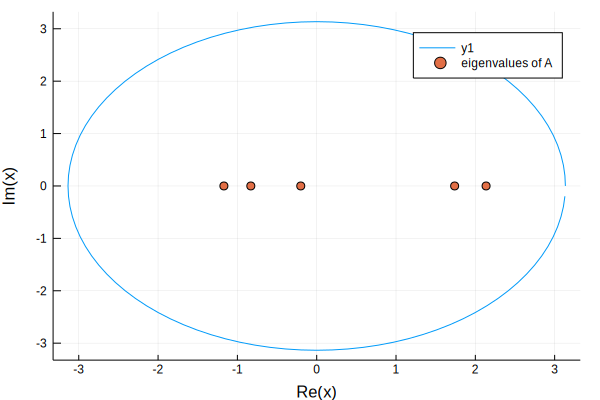

In [49]:
z,w = circle_rule(100,maximum(abs.(λ))+1)

plot(z)
scatter!(λ,zeros(5); label = "eigenvalues of A")

Here we wrap this up into a function `circle_exp` that calculates the matrix exponential:

In [50]:
function circle_exp(A, n, z₀, r)
    z,w = circle_rule(n,r)
    z .+= z₀

    ret = zero(A)
    for j=1:n
        ret += w[j]*exp(z[j])*inv(z[j]*I - A)
    end

    ret/(2π*im)
end
   
circle_exp(A, 100, 0, 8.0) -exp(A) |>norm

4.240422855934442e-13

In this case, it is beneficial to use an ellipse:

In [51]:
function ellipse_exp(A, n, z₀, a, b)
    z,w = ellipse_rule(n,a,b)
    z .+= z₀

    ret = zero(A)
    for j=1:n
        ret += w[j]*exp(z[j])*inv(z[j]*I - A)
    end
    ret/(2π*im)
end


ellipse_exp(A, 50, 0, 8.0, 5.0) -exp(A) |>norm

1.3594516845940306e-13

For matrices with large negative eigenvalues (For example, discretisations of the Laplacian), complex quadrature can lead to much better accuracy than Taylor series:

In [52]:
function taylor_exp(A,n)
    ret = Matrix(I, size(A))
    for k=1:n
        ret += A^k/factorial(1.0k)
    end
    ret
end

B = A - 20I

taylor_exp(B, 200) -exp(B) |>norm

4.813209010780333e-8

We can use an ellpise to surround the spectrum:

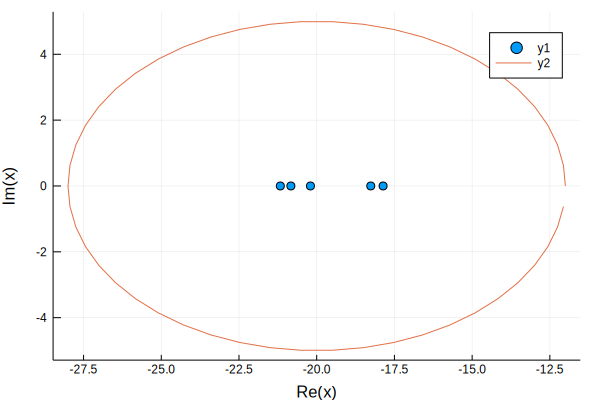

In [53]:
scatter(complex.(eigvals(B)))
plot!(ellipse_rule(50,8,5)[1] .- 20)

In [54]:
norm(ellipse_exp(B, 50, -20.0, 8.0, 5.0) - exp(B))

7.24987088647028e-22

### Gershgorin circle theorem

If we only know $A$, how do we know how big to make the contour? Gershgorin's circle theorem gives the answer:

**Theorem (Gershgorin)** Let $A \in {\mathbb C}^{d \times d}$ and define 
$$R_k = \sum_{j=1 \atop j \neq k}^d |a_{kj}| $$
Then 
$$
\rho(A) \subset \bigcup_{k=1}^d \bar B(a_{kk}, R_k)
$$
where $\bar B(z_0, r)$ is the closed disk of radius $r$ and $\rho(A)$ is the set of eigenvalues.

**Proof **


■

_Demonstration_ Here we apply this to a particular matrix:

In [55]:
A = [1 2 3; 1 5 2; -4 1 6]

3×3 Array{Int64,2}:
  1  2  3
  1  5  2
 -4  1  6

The following calculates the row sums:

In [56]:
R = sum(abs.(A - Diagonal(diag(A))),dims=2)

3×1 Array{Int64,2}:
 5
 3
 5

Gershgorin's theorem tells us that the spectrum lies in the union of the circles surrounding the diagonals:

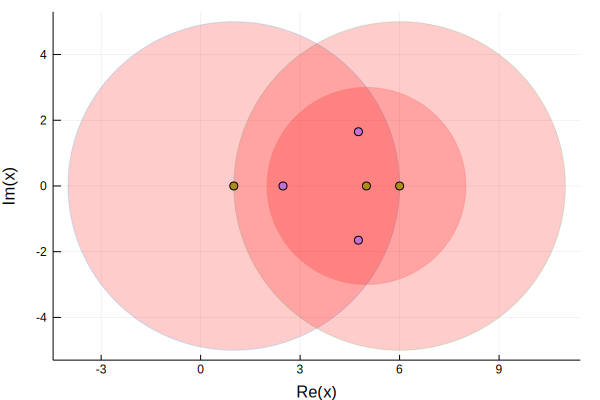

In [57]:
drawcircle!(z0, R) = plot!(θ-> real(z0) + R[1]*cos(θ), θ-> imag(z0) + R[1]*sin(θ), 0, 2π, fill=(0,:red), α = 0.2, legend=false)

λ = eigvals(A)
p = plot()
for k = 1:size(A,1)
    drawcircle!(A[k,k], R[k])
end
scatter!(complex.(λ); label="eigenvalues")
scatter!(complex.(diag(A)); label="diagonals")
p

We can therefore use this to choose a contour big enough to surround all the circles. Here's a fairly simplistic construction for our case where everything is real:

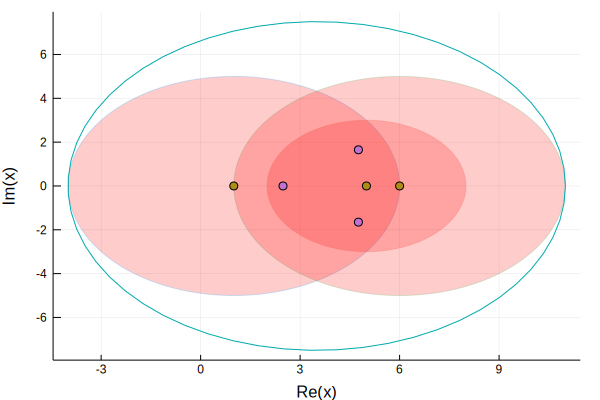

In [58]:
z₀ = (maximum(diag(A) .+ R) + minimum(diag(A) .- R)) /2 # average edges of circle
r = max(abs.(diag(A) .- R .- z₀)..., abs.(diag(A) .+ R .- z₀)...)

plot!(Circle(z₀, r))

## Fourier series and Laurent series 

**Definition (Fourier series)** On $[-\pi, \pi)$,  _Fourier series_ is an expansion of the form
$$
    g(\theta) = \sum_{k=-\infty}^\infty g_k e^{i k \theta}
$$
where
$$
g_k = {1\over 2 \pi} \int_{-\pi}^\pi g(\theta) e^{-i k \theta} d \theta
$$

**Definition (Laurent series)** In the complex plane, _Laurent series around $z_0$_ is an expansion of the form 
$$ 
    f(z) = \sum_{k=-\infty}^\infty f_k (z-z_0)^k 
$$    

**Lemma (Fourier series = Laurent series)** On a circle in the complex plane 
$$
    \gamma_r = \{z_0 + re^{i \theta} : -\pi \leq \theta < \pi \},$$ 
Laurent series of $f(z)$ around $z_0$ converges for $z \in C_r$ if the Fourier series of $g(\theta) = f(z_0 + r e^{i \theta})$ converges, and the coefficients are given by

$$ 
f_k = {g_k \over r^k} = {1 \over 2 \pi i} \oint_{\gamma_r} {f(\zeta) \over (\zeta - z_0)^{k+1}} d \zeta.
$$

**Proof**  This follows immediately from the change of variables $z = r \E^{\I \theta} + z_0$. ■

Interestingly, analytic properties of $f$ can be used to show decaying properties in $g$:

**Theorem (Decay in Fourier/Laurent coefficients)** Suppose $f(z)$ is analytic in a closed annulus $A_{r,R}$ around $0$:
$$A_r(z_0) = \{z : r ≤ | z| ≤ R\}$$
Then for all $k$
$$|f_k | \leq M\min\left\{{1 \over R^k} , {1 \over r^k}\right\}$$
where $M = \sup_{z \in  A} |f(z)|$.

**Proof**
This is a simple application of the ML lemma: 
$$
|f_k| = {1 \over 2 \pi } \left|\oint_{\gamma_1} {f(\zeta) \over \zeta^{k+1}} \D \zeta\right| = {1 \over 2 \pi}\left|\oint_{\gamma_r} {f(\zeta) \over \zeta^{k+1}} \D \zeta\right| \leq \sup_{\zeta \in \gamma_r} |f(\zeta)| R^{-k} \leq M R^{-k}
$$
which similar applies deforming to $\gamma_r$.
■



_Demonstration_ The Fourier coefficients of
$$g(\theta) = {1 \over 2 - \cos \theta}$$
satisfies for $k \geq 0$
$$
   |g_k| \leq {2 \over 4 - R -R^{-1}} R^{-k}
$$
for all $R \leq 2 + \sqrt{3}$:

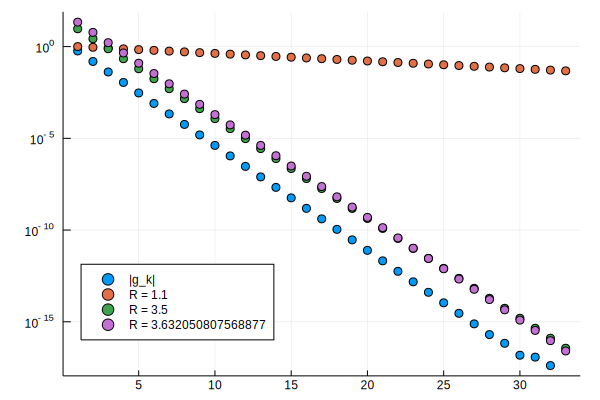

In [26]:
g =Fun(θ -> 1/(2-cos(θ)), Laurent(-π .. π))
g₊ = g.coefficients[1:2:end]
scatter(abs.(g₊); yscale=:log10, label="|g_k|", legend=:bottomleft)
R = 1.1
scatter!(2/(4-R-inv(R))*R.^(-(0:length(g₊))), label = "R = $R")
R = 3.5
scatter!(2/(4-R-inv(R))*R.^(-(0:length(g₊))), label = "R = $R")
R = 2+sqrt(3)-0.1
scatter!(2/(4-R-inv(R))*R.^(-(0:length(g₊))), label = "R = $R")